In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv('../dataset/tweets.csv')

In [3]:
df.head()

,id,handle,text,is_retweet,original_author,time,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,...,place_type,place_country_code,place_country,place_contained_within,place_attributes,place_bounding_box,source_url,truncated,entities,extended_entities
0,780925634159796224,HillaryClinton,The question in this election: Who can put the...,False,NaN,2016-09-28T00:22:34,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://studio.twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/Xr...,{'media': [{'display_url': 'pic.twitter.com/Xr...
1,780916180899037184,HillaryClinton,"Last night, Donald Trump said not paying taxes...",True,timkaine,2016-09-27T23:45:00,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,http://twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/t0...,{'media': [{'display_url': 'pic.twitter.com/t0...
2,780911564857761793,HillaryClinton,Couldn't be more proud of @HillaryClinton. Her...,True,POTUS,2016-09-27T23:26:40,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://about.twitter.com/products/tweetdeck,False,"{'user_mentions': [{'id_str': '1536791610', 'n...",NaN
3,780907038650068994,HillaryClinton,"If we stand together, there's nothing we can't...",False,NaN,2016-09-27T23:08:41,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://studio.twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/Q3...,{'media': [{'display_url': 'pic.twitter.com/Q3...
4,780897419462602752,HillaryClinton,Both candidates were asked about how they'd co...,False,NaN,2016-09-27T22:30:27,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://about.twitter.com/products/tweetdeck,False,"{'user_mentions': [], 'symbols': [], 'urls': [...",NaN


In [7]:
stopwords = [
  'the',
  'about',
  'an',
  'and',
  'are',
  'at',
  'be',
  'can',
  'for',
  'from',
  'if',
  'in',
  'is',
  'it',
  'of',
  'on',
  'or',
  'that',
  'this',
  'to',
  'you',
  'your',
  'with',
]

In [9]:
tfidf = TfidfVectorizer(max_features=100, stop_words=stopwords)
X = tfidf.fit_transform(text).todense()

In [10]:
N = X.shape[0]
idx = np.random.choice(N, size=2000, replace=False)
x = X[idx]
labels = df.handle[idx].tolist()

In [11]:
pTrump = sum(1.0 if e == 'realDonaldTrump' else 0.0 for e in labels) / len(labels)
print("proportion @realDonaldTrump: %.3f" % pTrump)
print("proportion @HillaryClinton: %.3f" % (1 - pTrump))

proportion @realDonaldTrump: 0.491
proportion @HillaryClinton: 0.508


In [12]:
dist_array = pdist(x)

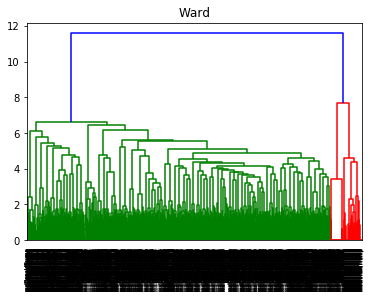

In [13]:
Z = linkage(dist_array, 'ward')
plt.title("Ward")
dendrogram(Z, labels=labels)
plt.show()

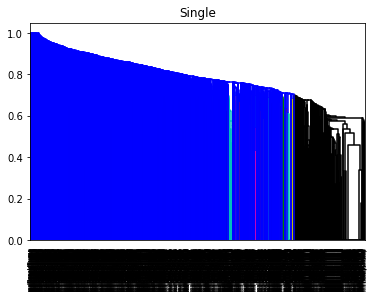

In [14]:
Z = linkage(dist_array, 'single')
plt.title("Single")
dendrogram(Z, labels=labels)
plt.show()

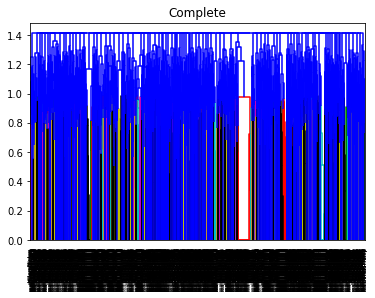

In [15]:
Z = linkage(dist_array, 'complete')
plt.title("Complete")
dendrogram(Z, labels=labels)
plt.show()

In [32]:
Y = np.array([1 if e == 'realDonaldTrump' else 2 for e in labels])

In [33]:
C = fcluster(Z, 9, criterion='distance') 
categories = set(C)
print("values in C:", categories)

values in C: {1}


In [18]:
def purity(true_labels, cluster_assignments, categories):
  # maximum purity is 1, higher is better
  N = len(true_labels)

  total = 0.0
  for k in categories:
    max_intersection = 0
    for j in categories:
      intersection = ((cluster_assignments == k) & (true_labels == j)).sum()
      if intersection > max_intersection:
        max_intersection = intersection
    total += max_intersection
  return total / N

print("purity:", purity(Y, C, categories))

purity: 0.4915


In [19]:
if (C == 1).sum() < (C == 2).sum():
  d = 1
  h = 2
else:
  d = 2
  h = 1

In [34]:
actually_donald = ((C == d) & (Y == 1)).sum()
donald_cluster_size = (C == d).sum()
print("purity of @realDonaldTrump cluster:", float(actually_donald) / donald_cluster_size)

purity of @realDonaldTrump cluster: nan


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:


actually_hillary = ((C == h) & (Y == 2)).sum()
hillary_cluster_size = (C == h).sum()
print("purity of @HillaryClinton cluster:", float(actually_hillary) / hillary_cluster_size)

purity of @HillaryClinton cluster: 0.5085


In [21]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X, df.handle)
print("classifier score:", rf.score(X, df.handle))

/opt/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


classifier score: 0.9615145872129113


In [22]:
w2i = tfidf.vocabulary_

In [26]:
d_avg = np.array(x[C == d].mean(axis=0)).flatten()
d_sorted = sorted(w2i.keys(), key=lambda w: -d_avg[w2i[w]])

print("\nTop 10 'Donald cluster' words:")
print("\n".join(d_sorted[:10]))


Top 10 'Donald cluster' words:
who
will
make
https
co
last
donald
trump
not
was


In [25]:
h_avg = np.array(x[C == h].mean(axis=0)).flatten()
h_sorted = sorted(w2i.keys(), key=lambda w: -h_avg[w2i[w]])

print("\nTop 10 'Hillary cluster' words:")
print("\n".join(h_sorted[:10]))


Top 10 'Hillary cluster' words:
co
https
trump
hillary
we
will
thank
realdonaldtrump
our
great
